# What is Credit Valuation Adjustment (CVA)?

CVA is waht the expected cost of counterparty credit risk is in Over-The-Counter (OTC) derivative contracts. It adjusts the risk-free value of a portfolio of derivative contracts by accounting for potential counterparty defaults.

The mathematical defintion for CVA is:



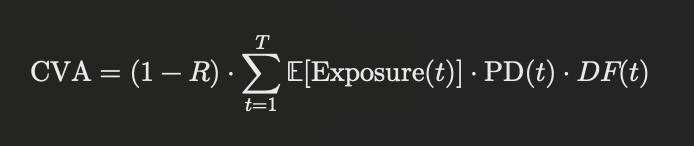

Where the values are:

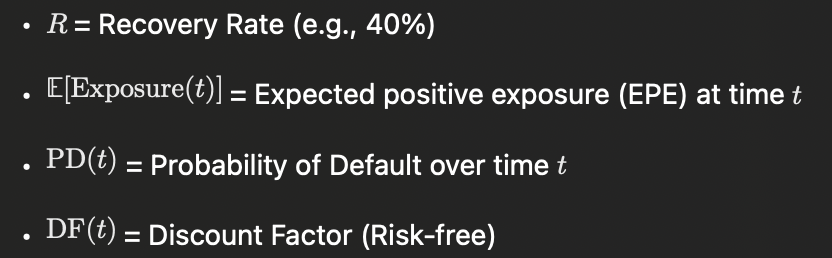

In [2]:
import yfinance as yf
import pandas as pd

# US 13-Week and 10-Year Treasury Rates
tickers = ["^IRX", "^TNX"]

# Gather the market data for the above Treasury rates
market_data = yf.download(tickers, start="2013-01-01", end="2024-12-16")
market_data['Adj Close'].head()


[*********************100%%**********************]  2 of 2 completed


,^IRX,^TNX
Date,,
2013-01-02,0.055,1.839
2013-01-03,0.065,1.899
2013-01-04,0.065,1.915
2013-01-07,0.058,1.903
2013-01-08,0.060,1.871


To calculate the CVA, we need to calculate the Exposure Calculation (Expected Positive Exposure - EPE)

To do this, we use the 'Interest Rate Swap' (IRS) example with a forward simulation. The forward simulation allows for the future projection of the floating rate of the interest swap. This allows for the value of the swap to be estimated at future times.


In [3]:
import numpy as np

class ExposureModel:
    # Notional is the principal from which the derivatives interest calculations
    # are based. The rate is the baseline interest rate.
    def simulate_exposure(notional, rate, maturity, simulations=10000):
        """
        This function simulates Expected Positive Exposur (EPE) for a Swap
        and assumes normal distribution of forward rates.
        """
        # Simulate rates using normal distribution
        simulated_rates = np.random.normal(rate, 0.01, simulations)
        
        # Calculate exposure
        exposures = np.maximum(simulated_rates - rate, 0) * notional
        expected_exposure = np.mean(exposures)
        return expected_exposure

In [4]:
notional = 1000000  # 1 million
fixed_rate = 0.02   # 2% fixed coupon
maturity = 5        # 5 years

exposure = ExposureModel.simulate_exposure(notional, fixed_rate, maturity)

# The Expected Positive Exposure is calculated to be $4,010.61
# this signifies that the positive exposure that the individual
# may obtain over the life of the contract is $4,010.61
print(f"Expected Positive Exposure (EPE): ${exposure:,.2f}")

Expected Positive Exposure (EPE): $3,869.63


This is a simplified model. In real-world scenarios, exposure modeling would be more complex and consider the contract structure, actual time steps, discounting of future cash flows, and more sophisticated interest rate modeling. But conceptually, this number is a rough gauge of the “benefit” you might have if future rates rise above your fixed coupon.

Next, we calculate the 'Probability of Default' using the default probability model which uses credit spreads from either CDS (Credit Default Swap) or corporate bonds

In [5]:
class DefaultModel:
    @staticmethod
    def default_probability(spread, maturity):
        """
        Estimates the default probability using credit spread.
        Assumes a risk-neutral world.
        """
        default_probability = 1 - np.exp(-spread * maturity)
        return default_probability

In [6]:
credit_spread = 0.02  # 2% credit spread
maturity = 5  # 5 years

pd = DefaultModel.default_probability(credit_spread, maturity)
print(f"Default Probability over {maturity} years: {pd:.4%}")

Default Probability over 5 years: 9.5163%


Finally now we have retrieved the Expected Positive Exposure (EPE), the probability of default and have the recovery rate. We can use these values to calculate the CVA.

In [7]:
class CVAModel:
    @staticmethod
    def calculate_cva(epe, pd, recovery_rate, discount_factor=0.95):
        """
        The discount factor  is a number used to determine the present value 
        of a future cash flow. It accounts for the time value of money and is 
        derived from current interest rates or yield curves.

        The recovery rate represents the proportion of principal that investors
        can expect to recover if a borrower defaults on its obligations. It is 
        usually estimated from historical default data, market observations, 
        or credit modeling.
        """
        """
        Calculate CVA using the risk-neutral approach
        """
        cva_value = (1 - recovery_rate) * epe * pd * discount_factor
        return cva_value

In [8]:
recovery_rate = 0.4  # 40% recovery
discount_factor = 0.95  # 5% discount for present value

cva = CVAModel.calculate_cva(exposure, pd, recovery_rate, discount_factor)
print(f"Calculated CVA: ${cva:,.2f}")

Calculated CVA: $209.90


The calculated CVA value of $217.55 means that, on average, the bank or institution expects to lose $217.55 on the contract due to the risk of counterparty default before the contract ends.

### Simulating Future Interest Rates using the Hull-White Method

Interest rate derivative models are used to price and manage interest rate derivatives such as swaps, caps, floors, swaptions and bond options.

The Hull-White is a short-rate moel an approach for interest rates modelling over time. It's an extention to the Vasieck model, which assumes mean-reverting process (meaning that it will return to its long-term average) for interest rates. The Hull-White model has a time-dependent drift term, this allows it to fit the initial term structure (the yield curve) exactly. 

The Hull- White formula is as follows:

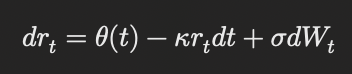

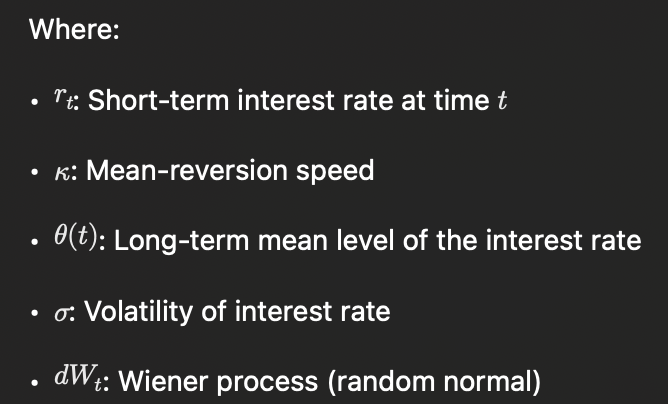

Short rate: 0.04218
Long rate: 0.04399


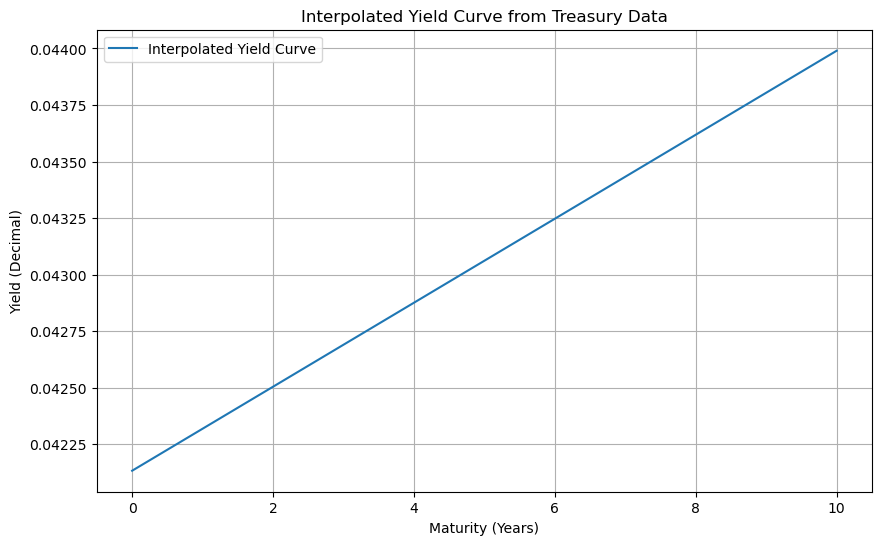

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Extract Treasury rates from the market data retrieved from above
yield_curve_data = market_data['Adj Close'][['^IRX', '^TNX']].dropna()

# Here IRX is the Treasury Bill yield (short-term rate) 13-weeks
# and TNX is the Treasury Note yield (long-term rate) 10 year 

# Convert to decimal format
yield_curve_data['^IRX'] /= 100
yield_curve_data['^TNX'] /= 100

# Taking the latest available yields
short_rate = yield_curve_data['^IRX'].iloc[-1]
print("Short rate:", round(short_rate,5))
long_rate = yield_curve_data['^TNX'].iloc[-1]
print("Long rate:", round(long_rate,5))

# Maturities corresponding to these rates
maturities = np.array([0.25, 10])  # 13 weeks = 0.25 years

# Below is to create a yield curve using interpolation that estimates yield for any maturity between 13 weeks and 10years
# Interpolate the yield curve
interp_yield_curve = interp1d(maturities, [short_rate, long_rate], kind='linear', fill_value="extrapolate")

# Plot the interpolated yield curve
future_maturities = np.linspace(0, 10, 100)
interpolated_yields = interp_yield_curve(future_maturities)

plt.figure(figsize=(10, 6))
plt.plot(future_maturities, interpolated_yields, label='Interpolated Yield Curve')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (Decimal)")
plt.title("Interpolated Yield Curve from Treasury Data")
plt.grid(True)
plt.legend()
plt.show()

We can now implement the Hull-White monte carlo simulation as follows:

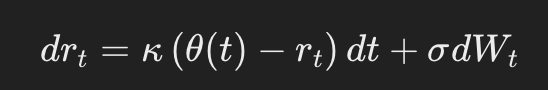

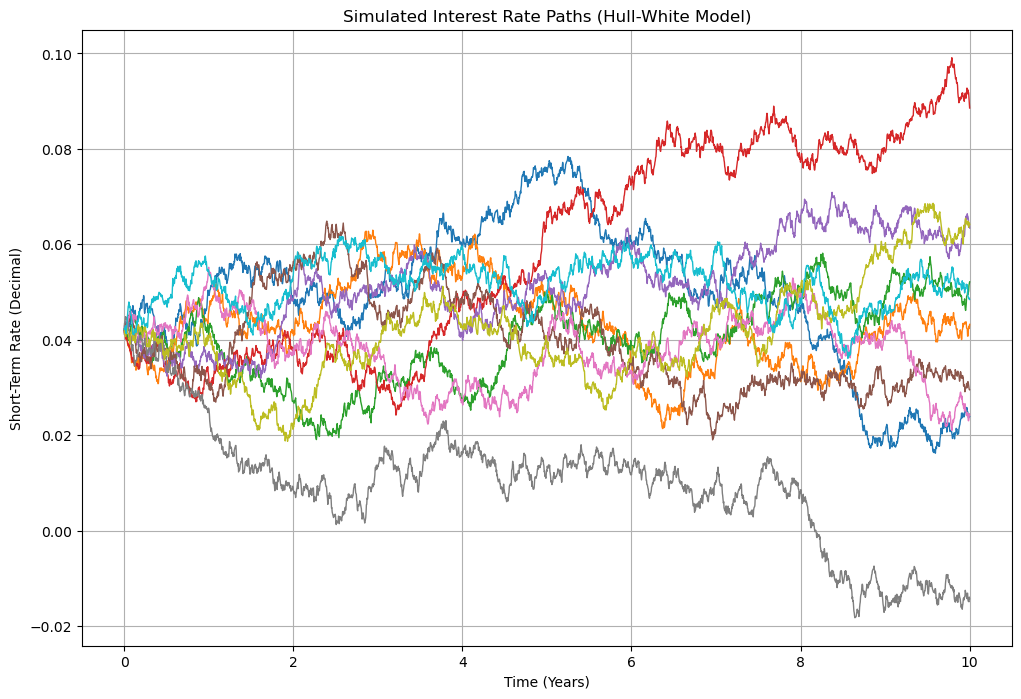

In [16]:
class HullWhiteModel:
    def __init__(self, mean_reversion_speed, volatility, initial_rate):
        self.kappa = mean_reversion_speed
        self.sigma = volatility
        self.r0 = initial_rate

    def simulate(self, T, dt, n_simulations):
        """
        Simulate short-term interest rates using Hull-White model.
        
        T: Total time of each simulation in years
        dt: Time step size
        n_simulations: Number of simulations, Monte Carlo paths
        """
        # The number of time/simulation steps is taken by time in years/the time step size
        n_steps = int(T / dt)

        # Here we are initialising an array of rates with the following shape of zeros:
        rates = np.zeros((n_steps + 1, n_simulations))
        # We then set the initial_rate for all simulations
        rates[0] = self.r0

        for t in range(1, n_steps + 1):
            # the Weiner process, random brownian motion increments
            dw = np.random.normal(0, np.sqrt(dt), n_simulations)
            # Earlier mentioned Hull_white equation is simplified however this is original showed above
            dr = self.kappa * (interp_yield_curve(t * dt) - rates[t-1]) * dt + self.sigma * dw
            # Here we Updates the short-term interest rates for the current time step by adding the calculated change.
            rates[t] = rates[t-1] + dr

        time_grid = np.linspace(0, T, n_steps + 1)
        return time_grid, rates

# Initialize model with example parameters
hw_model = HullWhiteModel(mean_reversion_speed=0.03, 
                          volatility=0.01, 
                          initial_rate=short_rate)

# Simulate rates for 10 years
T = 10  # Simulation horizon in years
dt = 1 / 252  # Daily time steps
n_simulations = 1000

time_grid, simulated_rates = hw_model.simulate(T, dt, n_simulations)

# Plot some paths
plt.figure(figsize=(12, 8))
for i in range(10):  # Show 10 simulated paths
    plt.plot(time_grid, simulated_rates[:, i], lw=1)

plt.xlabel("Time (Years)")
plt.ylabel("Short-Term Rate (Decimal)")
plt.title("Simulated Interest Rate Paths (Hull-White Model)")
plt.grid(True)
plt.show()

Now we have simulated future interest rates using the Hull-White model, we can now calculate the future value of the IRS (Interest Rate Swap), at simulated time steps. We will use the Interest Rate Swap Valuation Model, which is a financial model used to determine what the fair price of a IRS is based on calculating its present value.  This is done by using the short term interest rates simulated from the above Hull-White model. 

For the IRS Valuation Model, the steps are:

1) Fixed Leg:
- A fixed interest rate paid throughout the contracts life.

2) Floating Leg:
- Pays an interest rate which is linked to the market index (e.g. IBOR or SOFR) or in our case we will be using the simulated short-term rates.

3) (Finally) The net-present value of the IRS can be calculated:
- It is the sum of the discounted floating leg - discounted fixed leg


In [83]:
import numpy as np

class IRSValuation:
    def __init__(self, notional, fixed_rate, maturity, payment_frequency):
        self.notional = notional
        self.fixed_rate = fixed_rate
        self.maturity = maturity
        self.payment_frequency = payment_frequency
        self.time_steps = int(self.maturity * self.payment_frequency)
        self.dt = 1 / self.payment_frequency

    def calculate_cash_flows(self, floating_rates):
        """
        Calculate cash flows for fixed and floating legs.
        floating_rates: Simulated short-term rates (2D array)
        """
        n_simulations = floating_rates.shape[1]

        # Fixed leg cash flows
        fixed_cash_flows = np.full((self.time_steps, n_simulations), self.notional * self.fixed_rate * self.dt)

        # Floating leg cash flows depend on simulated rates
        floating_cash_flows = self.notional * floating_rates[:self.time_steps] * self.dt
        
        return fixed_cash_flows, floating_cash_flows

    def calculate_discount_factors(self, rates):
        """
        Correct Discount Factor Calculation.
        Ensure correct time grid length.
        """
        n_steps = rates.shape[0]  # Ensure correct time steps
        time_grid = np.linspace(0, (n_steps - 1) * self.dt, n_steps - 1)

        # Cumulative sum of rates for discounting
        discount_factors = np.exp(-np.cumsum(rates[:self.time_steps], axis=0) * self.dt)

        return time_grid, discount_factors

    def calculate_npv(self, fixed_cf, floating_cf, discount_factors):
        """
        Calculate NPV as the difference between floating and fixed legs.
        """
        fixed_leg_pv = fixed_cf * discount_factors
        floating_leg_pv = floating_cf * discount_factors

        # Net Present Value (NPV)
        irs_npv = floating_leg_pv - fixed_leg_pv
        return irs_npv

In [91]:
# Initialize IRS model with daily steps
notional = 1_000_000  # 1 million USD
fixed_rate = 0.02  # 2% fixed coupon
maturity = 5  # 5 years
payment_frequency = 252  # Daily payments (252 trading days)
n_simulations = 10_000

# Simulate interest rates using the Hull-White model
time_grid, simulated_rates = hw_model.simulate(T=maturity, dt=1/252, n_simulations=n_simulations)

# Initialize IRS valuation model
irs_model = IRSValuation(notional, fixed_rate, maturity, payment_frequency)

# Calculate cash flows and discount factors
fixed_cf, floating_cf = irs_model.calculate_cash_flows(simulated_rates)
time_grid, discount_factors = irs_model.calculate_discount_factors(simulated_rates)

# Calculate NPV
irs_npv = irs_model.calculate_npv(fixed_cf, floating_cf, discount_factors)
print(f"IRS NPV shape: {irs_npv.shape}")  # Expected (time_steps, n_simulations)|

IRS NPV shape: (1260, 10000)


We can now calculate the CVA using the above mentioned formula, where the LGD = (1-Recovery rate), the default fixed value given by regulators Basel 3.

To do this, we:

1) Calculate the EPE at each time step.
2) Calculate the default probability, this can be done using a flat hazard rate or a time-varying spread.
3) Use the simulated interest rates to calculate discounting
4) Finally, aggregate the expected discount losses

In [99]:
class CVACalculator:
    def __init__(self, recovery_rate):
        self.recovery_rate = recovery_rate

    def calculate_epe(self, npv_matrix):
        """
        Calculate Expected Positive Exposure (EPE).
        Ensure input is a 2D array.
        """
        npv_matrix = np.atleast_2d(npv_matrix)
        epe = np.maximum(npv_matrix, 0).mean(axis=1)
        return epe

    def calculate_default_prob(self, hazard_rate, time_grid):
        """
        Correct Default Probability Calculation.
        Ensure the correct length of PD.
        """
        pd = 1 - np.exp(-hazard_rate * time_grid[:len(time_grid)])
        return pd

    # def calculate_cva(self, epe, pd, discount_factors):
    #     """
    #     Correct CVA Calculation with Proper Broadcasting.
    #     Expand EPE and PD to match the shape of Discount Factors.
    #     """
    #     # Reshape EPE and PD to match Discount Factors
    #     epe = np.tile(epe.reshape(-1, 1), discount_factors.shape[1])  # Expand to (1260, 10000)
    #     pd = np.tile(pd.reshape(-1, 1), discount_factors.shape[1])    # Expand to (1260, 10000)
        
    #     # Element-wise multiplication and sum
    #     cva = (1 - self.recovery_rate) * np.sum(epe * pd * discount_factors)
    #     return cva
    
    def calculate_cva(self, epe, pd, discount_factors):
        """
        Correct CVA Calculation:
        - Take the average across all simulations.
        - Use time-weighted expected loss at each time step.
        """
        # Expand EPE and PD to match discount_factors' shape
        epe_expanded = np.tile(epe.reshape(-1, 1), discount_factors.shape[1])
        pd_expanded = np.tile(pd.reshape(-1, 1), discount_factors.shape[1])

        # Element-wise multiplication, take mean across simulations
        time_weighted_losses = epe_expanded * pd_expanded * discount_factors
        cva = (1 - self.recovery_rate) * np.mean(time_weighted_losses, axis=1).sum()

        return cva

In [100]:
# Initialize CVA calculator
recovery_rate = 0.4  # 40% recovery
hazard_rate = 0.02  # Flat 2% credit spread

cva_calculator = CVACalculator(recovery_rate)

# Recalculate EPE, PD, and CVA
epe = cva_calculator.calculate_epe(irs_npv)
pd = cva_calculator.calculate_default_prob(hazard_rate, time_grid)

# Ensure consistent shapes before CVA calculation
print(f"EPE shape: {epe.shape}, PD shape: {pd.shape}, Discount Factors shape: {discount_factors.shape}")

# Calculate CVA
cva_value = cva_calculator.calculate_cva(epe, pd, discount_factors)

# Display Results
print(f"Calculated CVA: ${cva_value:,.2f}")

EPE shape: (1260,), PD shape: (1260,), Discount Factors shape: (1260, 10000)
Calculated CVA: $2,482.45


In [101]:
discount_factors

array([[0.99983263, 0.99983263, 0.99983263, ..., 0.99983263, 0.99983263,
        0.99983263],
       [0.99966039, 0.99966671, 0.99966348, ..., 0.99966555, 0.9996557 ,
        0.99967089],
       [0.99948609, 0.99949956, 0.99949908, ..., 0.99950012, 0.99947484,
        0.99950886],
       ...,
       [0.74505923, 0.85499576, 0.76038519, ..., 0.8420623 , 0.73238289,
        0.80420978],
       [0.74491216, 0.8549388 , 0.76021306, ..., 0.84203419, 0.7321858 ,
        0.80407732],
       [0.74476633, 0.8548843 , 0.76003723, ..., 0.84200879, 0.73198524,
        0.80394185]])

In [102]:
# Check Discount Factors at the Last Time Step
print(f"Final Discount Factor Mean: {np.mean(discount_factors[-1]):.4f}")

Final Discount Factor Mean: 0.8114


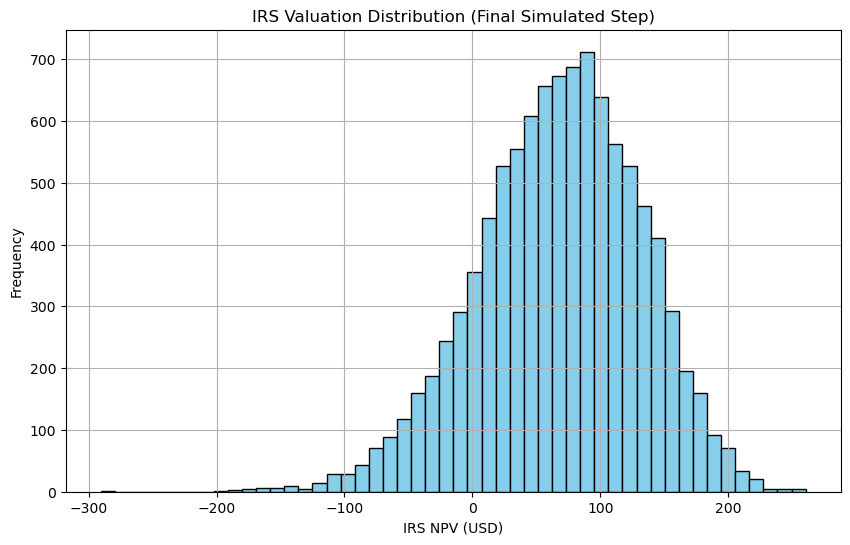

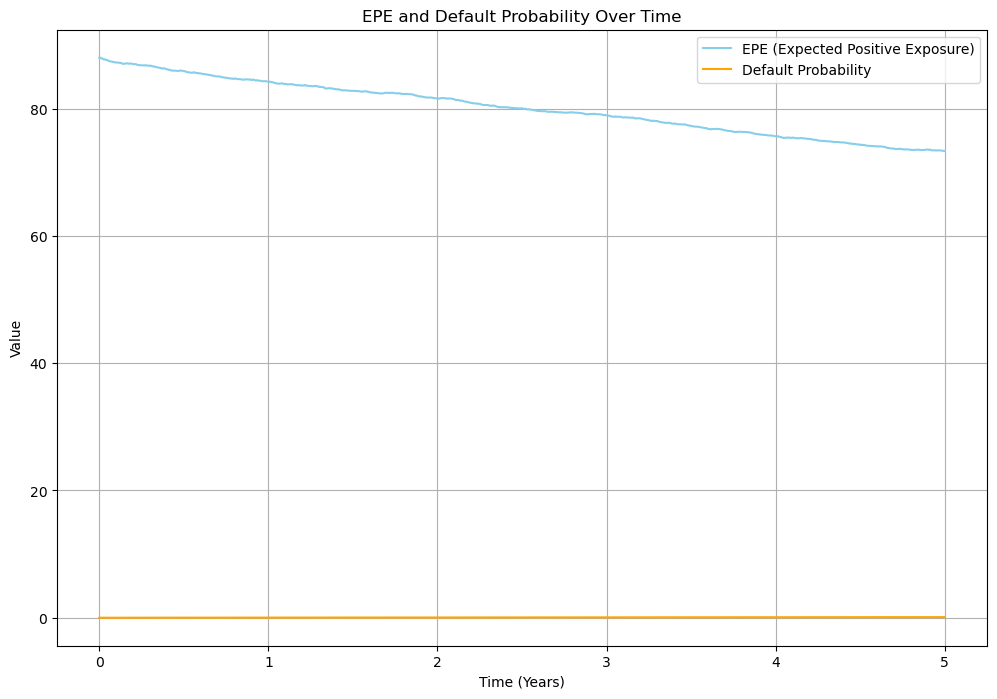

In [103]:
import matplotlib.pyplot as plt

# Plot the histogram of IRS NPV at the final time step
final_npv = irs_npv[-1]  # Use only the final time step
plt.figure(figsize=(10, 6))
plt.hist(final_npv, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("IRS NPV (USD)")
plt.ylabel("Frequency")
plt.title("IRS Valuation Distribution (Final Simulated Step)")
plt.grid(True)
plt.show()

# Plot EPE and Default Probability over time
plt.figure(figsize=(12, 8))
plt.plot(time_grid, epe, label="EPE (Expected Positive Exposure)", color="skyblue")
plt.plot(time_grid, pd, label="Default Probability", color="orange")
plt.xlabel("Time (Years)")
plt.ylabel("Value")
plt.title("EPE and Default Probability Over Time")
plt.grid(True)
plt.legend()
plt.show()

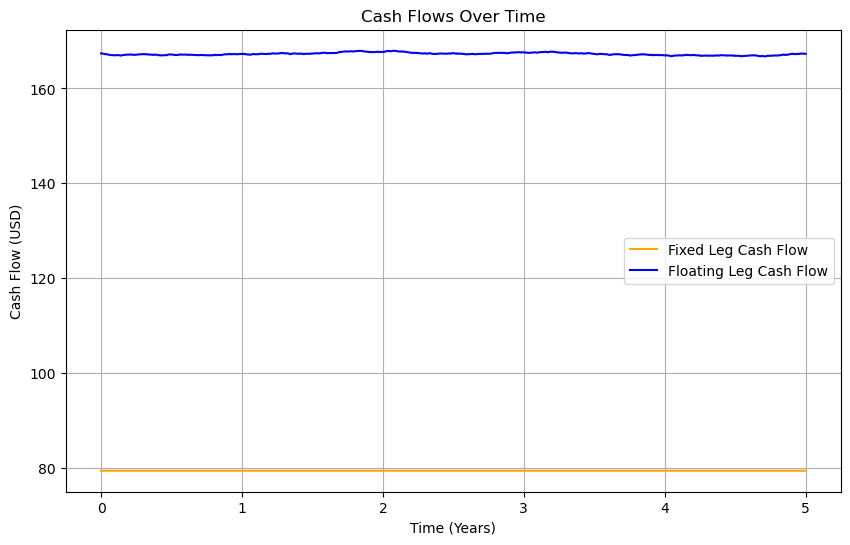

In [104]:
# Visualize Floating and Fixed Leg Cash Flows
plt.figure(figsize=(10, 6))
plt.plot(time_grid, fixed_cf.mean(axis=1), label="Fixed Leg Cash Flow", color="orange")
plt.plot(time_grid, floating_cf.mean(axis=1), label="Floating Leg Cash Flow", color="blue")
plt.xlabel("Time (Years)")
plt.ylabel("Cash Flow (USD)")
plt.title("Cash Flows Over Time")
plt.grid(True)
plt.legend()
plt.show()

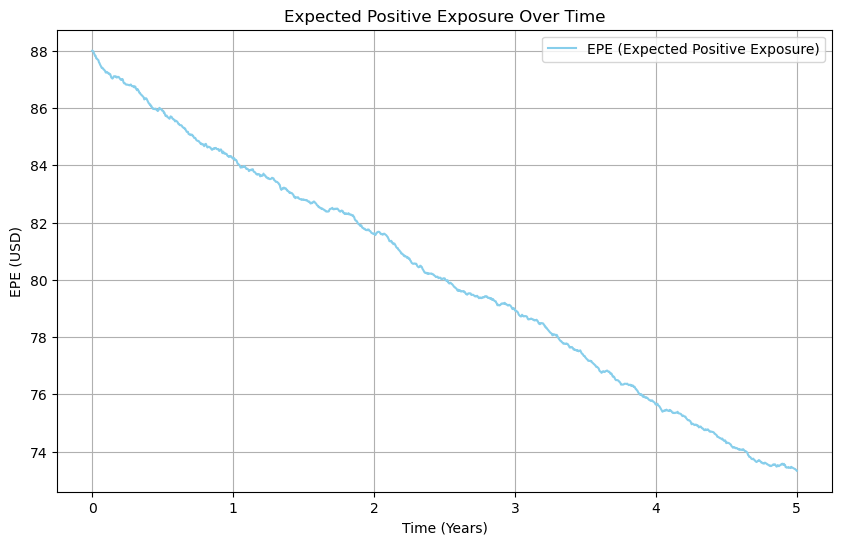

In [105]:
# Visualize EPE over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(time_grid, epe, label="EPE (Expected Positive Exposure)", color="skyblue")
plt.xlabel("Time (Years)")
plt.ylabel("EPE (USD)")
plt.title("Expected Positive Exposure Over Time")
plt.grid(True)
plt.legend()
plt.show()

## Wrong-way Risk and Right-way Risk

These are two types of risks that arise in the realm of counterparty risk. Furthermore Wrong Way Risk (WWR) can be classified into Specific Wrong Way Risk (SWWR) and General Wrong Way Risk (GWWR).

What is Wrong Way Risk?

WWR is a form of counterparty risk, where the exposure to a counterparty increases with the risk of counterparty's default (e.g. their credit quality decreases). An example would be a credit default swap: 

Where lets say an individual Bob has a corporate bond from Microsoft, to protect himself Bob buys a CDS (credit default swap) from Virgin Bank, so that if Microsoft defaults, Virgin Bank will pay the remainder of the Bond. However, there can be a scenario where Microsoft defaults and since Virgin Bank has Microsoft asssets which are now 0, they cannot pay this bond value back to Bob. - WWR

Specific Wrong Way Risk is when the risk comes from either a direct legal or economic reltationship between the exposure and the ounterparties default probability.

General Wrong Way Risk is when the risk comes from the broader market conditions or correlations not directly related to the contract terms.

Right way risk is the opposite. Here the credit exposure to a counterparty decreases when the counterparty's credit worthiness deteriorates. 